# MAP 568 Project

Maxime Vincent & Swann Chelly

In [1]:
import numpy as np

from constant import *
from scipy import *
from scipy import stats
from pylab import *     
from scipy.integrate import odeint # Module de résolution des équations différentielles
import plotly as po
from progressbar import ProgressBar
import matplotlib.pyplot as plt

In [2]:
def euler_one_step(S,I_moins,I_plus,R_moins,R_plus_I,H,U,R_plus_H,D,D_R,i,constants,variables, deltaT):
    S_1        = S-constants['tau'][i]*S*I_moins*deltaT
    I_moins_1  = I_moins + (constants['tau'][i]*S*I_moins-variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_moins)*deltaT
    I_plus_1   = I_plus +(variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_plus)*deltaT
    R_moins_1  = R_moins +(constants['gamma_IR']*I_moins)*deltaT
    R_plus_I_1 = R_plus_I + (constants['gamma_IR']*I_plus)*deltaT
    H_1        = H + (constants['gamma_IH']*(I_moins + I_plus)-(constants['gamma_HR']+constants['gamma_HD']+constants['gamma_HU'])*H)*deltaT
    U_1        = U + (constants['gamma_IU']*(I_moins + I_plus)+constants['gamma_HU']*H-(constants['gamma_UR'] + constants['gamma_UD'])*U)*deltaT
    R_plus_H_1 = R_plus_H+ (constants['gamma_HR']*H+constants['gamma_UR']*U)*deltaT
    D_1        = D + (constants['gamma_UD']*U+constants['gamma_HD']*H)*deltaT  
    D_R_1      = D_R +((variables['lambda_1']+constants['gamma_IH']+constants['gamma_IU'])*I_moins-D_R)*deltaT
    
    
    return(S_1,I_moins_1,I_plus_1,R_moins_1,R_plus_I_1,H_1,U_1,R_plus_H_1,D_1,D_R_1)


def resolution_systeme(deltaT,constants, variables, set_size = global_constants['set_size']):
    Res = np.zeros((10,set_size))
    Res[0,0] = global_constants['S_0']
    Res[1,0] = variables['I_moins_0']
    
    for i in range(1,set_size):
        Res[:,i] = euler_one_step(Res[0,i-1],Res[1,i-1],Res[2,i-1],Res[3,i-1],Res[4,i-1],Res[5,i-1],Res[6,i-1],Res[7,i-1],Res[8,i-1],Res[9,i-1],i,constants, variables, deltaT)
 
    return Res



## Incertitudes en sortie

1) **Programmer la résolution du système (1-10).**

Dans le fichier constant nous définissons l'ensemble des constantes. La fonction `init_constant` de ce fichier renvoie un dictionnaire généré aléatoirement de constantes. 

In [3]:
## Résolution de l'équation différentielle. 

def equa_diff(syst,temps):
    
    """
    La résolution du système d'équation différentiel (1-10) se fait grace au module odeint de scipy.integrate.
    
    Paramètres :
    ------------
    
    syst : tableau, 
        Conditions initiales.
    
    temps : float,
        
    
    Sorties : 
    ---------
    Ensemble des paramètres du système différentiel. 
    
    """
    tau = cst['tau_0']*np.exp(-cst['mu']*max(temps-cst['N'],0))
    S = syst[0] 
    I_moins = syst[1] 
    I_plus = syst[2] 
    R_moins = syst[3] 
    R_plus_I = syst[4] 
    H = syst[5] 
    U = syst[6] 
    R_plus_H = syst[7] 
    D = syst[8] 
    D_R = syst[9]
    # Dérivées des variables
    DS = -tau*S*I_moins
    DI_moins = tau*S*I_moins-cst['lambda_1']*I_moins-(cst['gamma_IR']+cst['gamma_IH']+cst['gamma_IU'])*I_moins
    DI_plus = cst['lambda_1']*I_moins-(cst['gamma_IR']+cst['gamma_IH']+cst['gamma_IU'])*I_plus
    DR_moins = cst['gamma_IR']*I_moins-cst['lambda_2']*R_moins
    DR_plus_I = cst['gamma_IR']*I_plus+cst['lambda_2']*R_moins
    DH = cst['gamma_IH']*(I_moins + I_plus)-(cst['gamma_HR']+cst['gamma_HD']+cst['gamma_HU'])*H
    DU = cst['gamma_IU']*(I_moins + I_plus)+cst['gamma_HU']*H-(cst['gamma_UR'] + cst['gamma_UD'])*U
    DR_plus_H = cst['gamma_HR']*H+cst['gamma_UR']*U
    DD = cst['gamma_UD']*U+cst['gamma_HD']*H  
    DD_R = (cst['lambda_1']+cst['gamma_IH']+cst['gamma_IU'])*I_moins-D_R
    
    
    return(DS,DI_moins,DI_plus,DR_moins,DR_plus_I,DH,DU,DR_plus_H,DD,DD_R)


1


Text(0, 0.5, 'Nombre de personne en réanimation')

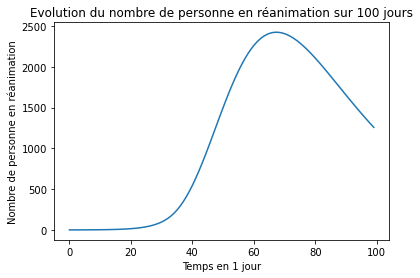

In [3]:
# Analyse des résultats

#cst = init_constant()
#syst_CI=array([cst['S_0'],cst['I_moins_0'],0,0,0,0,0,0,0,0])
#simulation=odeint(equa_diff,syst_CI,t)
variables = init_variables(deltaT=global_constants['deltaT'],global_constants = global_constants)
constants = compute_constants(variables)
#syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
#print(global_constants['deltaT'])
simulation = resolution_systeme(global_constants['deltaT'],constants, variables, set_size = global_constants['set_size'])

plt.plot(simulation[6])
plt.title(f"Evolution du nombre de personne en réanimation sur {global_constants['T_MAX']} jours")
plt.xlabel(f"Temps en {global_constants['deltaT']} jour")
plt.ylabel("Nombre de personne en réanimation")




2) **Par échantillonnage Monte Carlo (en utilisant les lois des paramètres d'entrée de la table 1), donner :**
- la loi du nombre maximal de patients présents en soins intensifs (histogramme, moyenne, quantiles à 10% et 90%),
- la loi de la date du pic de l'épidémie.

In [7]:
## Implémentation de la méthode de Monte Carlo classique pour la résolution du système différentiel. 

M = 10000
#deltaT=1

def Monte_Carlo(M):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    M : int, 
        Taille de l'échantillon. 
    
    Sorties : 
    ---------
    peak_value  : list,
        Nombre de cas en réanimation au pic de l'épidémie pour chaque simulation.
    peak_day    : list, 
        Jour du pic pour chaque simulation.
    pos         : list, 
        Nombre de cas au pic de l'épidémie pour chaque simulation.
    
    """
    
    print(f"Echantillonnage de Monte Carlo sur 10000 simulation")
    peak_value,peak_day, pos = [],[], []
    pbar = ProgressBar()
    for i in pbar(range(M)):
        #cst = init_constant()
        #syst_CI=array([cst['S_0'],cst['I_moins_0'],0,0,0,0,0,0,0,0]) 
        variables = init_variables(deltaT=1,global_constants = global_constants)
        constants = compute_constants(variables)
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        #simulation=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))   
        #simulation=odeint(equa_diff,syst_CI,t) 
        simulation = resolution_systeme(global_constants['deltaT'],constants, variables, set_size = global_constants['set_size'])
        peak_value.append(np.max(simulation[6]))
        peak_day.append(int(np.argmax(list(simulation[6]))*global_constants['deltaT']))
        pos.append(np.max(simulation[1]))
        
    return (peak_value,peak_day,pos)

peak_value,peak_day,pos = Monte_Carlo(M)


  0% (42 of 10000) |                     | Elapsed Time: 0:00:00 ETA:   0:00:47

Echantillonnage de Monte Carlo sur 10000 simulation


100% (10000 of 10000) |##################| Elapsed Time: 0:00:36 Time:  0:00:36


La valeur moyenne du pic est de 20796.02 et appartient à l'intervalle de confiance à 95% suivant : [19734.13,21857.92] 
 Le quantile à 10% du pic de réanimation est : 26.687890416615694
 Le quantile à 90% du pic de réanimation est : 61171.511771934376


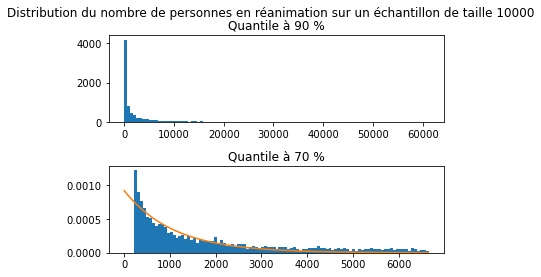

In [8]:
mean_value = np.mean(peak_value)
var_value  = np.var(peak_value)
q_10 = np.quantile(peak_value, 0.1, axis = None)
q_30 = np.quantile(peak_value, 0.3, axis = None)
q_50 = np.quantile(peak_value, 0.5, axis = None)
q_70 = np.quantile(peak_value, 0.7, axis = None)
q_90 = np.quantile(peak_value, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_value,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_value-1.96*np.sqrt(var_value/M),2))},{round(mean_value+1.96*np.sqrt(var_value/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 


fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du nombre de personnes en réanimation sur un échantillon de taille {M}")
axs[0].hist([value for value in peak_value if value < q_90], bins = 100)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([value for value in peak_value if (value > q_30 and value < q_70)], bins = 100, density = True)
axs[1].set_title('Quantile à 70 %')
x=np.arange(0,max([value for value in peak_value if (value < q_70)]), 0.01)
Moy = np.mean([value for value in peak_value if (value < q_70)])
axs[1].plot(x,stats.expon.pdf(x, scale=Moy), label="densité") 
plt.subplots_adjust(hspace=0.5)

3385.951154334534

In [10]:
lol = [value for value in peak_value if value < q_70]
lol2 = [value for value in peak_value if (value < q_70 and value > q_10)]
print(len(lol), len(lol2))
                                          

7000 6000


En supposant que la distribution du nombre de cas en réanimation au pic de l'épidémie suis une loie exponentielle, nous pouvons donner son paramètre $\lambda = \frac{1}{\mathbb{\hat{E}}(X)}$ où $X$ correspond à la variable aléatoire liée au nombre de cas en réanimation au pic de l'épidémie. Nous la notrons ici `lbd`.


(array([6.33251487e-05, 6.07751427e-05, 5.45417947e-05, 4.93001158e-05,
        4.66792763e-05, 3.91000918e-05, 3.57000838e-05, 3.10250728e-05,
        3.04584048e-05, 2.63500619e-05, 2.61375614e-05, 2.06833819e-05,
        2.16750509e-05, 1.91250449e-05, 1.92667119e-05, 1.53708694e-05,
        1.26791964e-05, 1.40250329e-05, 1.17583609e-05, 9.13752145e-06,
        1.01291904e-05, 8.64168696e-06, 8.14585246e-06, 5.80834697e-06,
        7.08334996e-06, 6.58751547e-06, 5.10001197e-06, 4.67501098e-06,
        4.46251048e-06, 3.61250848e-06, 3.54167498e-06, 3.11667398e-06,
        2.47917249e-06, 2.90417349e-06, 2.55000599e-06, 2.12500499e-06,
        2.26667199e-06, 2.12500499e-06, 1.48750349e-06, 1.13333599e-06,
        9.20835495e-07, 9.91668995e-07, 7.79168496e-07, 3.54167498e-07,
        5.66667997e-07, 9.91668995e-07, 4.25000998e-07, 8.50001996e-07,
        4.25000998e-07, 9.20835495e-07, 4.95834498e-07, 4.95834498e-07,
        7.08334996e-07, 2.83333999e-07, 4.95834498e-07, 6.375014

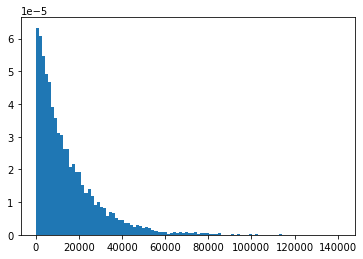

In [47]:
lbd = 1/mean_value

Y = np.random.exponential(1/lbd,10000)
plt.hist(Y,bins = 100,density = True)

La valeur moyenne du pic est de 62.61 et appartient à l'intervalle de confiance à 95% suivant : [62.24,62.98] 
 Le quantile à 10% du pic de réanimation est : 39.0
 Le quantile à 90% du pic de réanimation est : 93.0


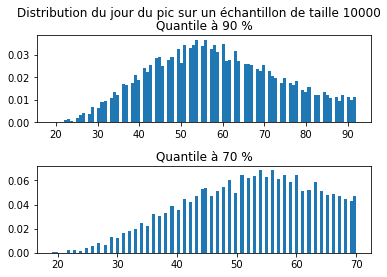

In [58]:
# Loi de la date de l'épidémie. 

mean_day = np.mean(peak_day)
var_day  = np.var(peak_day)
q_10_day = np.quantile(peak_day, 0.1, axis = None)
q_70_day = np.quantile(peak_day, 0.7, axis = None)
q_90_day = np.quantile(peak_day, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_day,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_day-1.96*np.sqrt(var_day/M),2))},{round(mean_day+1.96*np.sqrt(var_day/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10_day}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90_day}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 

fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du jour du pic sur un échantillon de taille {M}")
axs[0].hist([day for day in peak_day if day < q_90_day], bins = 100, density = True)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([day for day in peak_day if day < q_70_day], bins = 100, density = True)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

(array([0.00208333, 0.        , 0.00208333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00625   , 0.        ,
        0.00625   , 0.        , 0.01875   , 0.        , 0.01458333,
        0.        , 0.02916667, 0.        , 0.03541667, 0.        ,
        0.03958333, 0.        , 0.03125   , 0.        , 0.        ,
        0.06041667, 0.        , 0.04791667, 0.        , 0.06875   ,
        0.        , 0.07083333, 0.        , 0.125     , 0.        ,
        0.09791667, 0.        , 0.12083333, 0.        , 0.12291667,
        0.        , 0.08541667, 0.        , 0.12083333, 0.        ,
        0.12708333, 0.        , 0.12291667, 0.        , 0.        ,
        0.13958333, 0.        , 0.09791667, 0.        , 0.06458333,
        0.        , 0.06458333, 0.        , 0.06875   , 0.        ,
        0.06041667, 0.        , 0.05416667, 0.        , 0.04583333,
        0.        , 0.02083333, 0.        , 0.02291667, 0.        ,
        0.02916667, 0.        , 0.01666667, 0.  

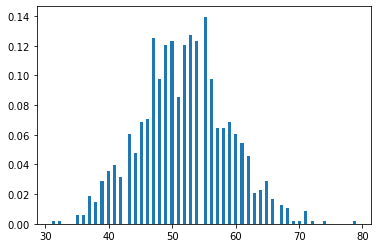

In [59]:
#x=np.arange(0,max([value for value in peak_day if (value < q_90_day)]), 0.01)

#tracées loi de poisson

Esp = np.mean([value for value in peak_day if (value < q_70_day)])
plt.hist(stats.poisson.rvs(mu = Esp, size = 1000), bins = 100, density = True)

Consider an economy with a risk-free security with a fixed interest
rate r and a single risky security paying $\widetilde{a}$ in the
future and for which investors receive private signals, $\widetilde{S_{i}}$
for individual i. To simplify, take r = 0. Formally, we take the CARA-normal
assumptions with utility function : $u(x)=-\rho e^{-\rho x}$\

\begin{align*} 
INSERT Définition\\
\end{align*} 
The Model : 

We consider two types of rational investor :

An informed investor (or insider), receiving the signal $\widetilde{s}$,
whose risk aversion is $\rho^{1}$ and whose initial portfolio is
$z^{1}(0)$
An uninformed investor whose risk aversion is $\rho^{2}$ with initial
portfolio $z^{2}(0)$
The vector ($\widetilde{a},\widetilde{s},\widetilde{n}$) is normal,
the expectation of $\widetilde{n}$ is zero, and $Var(\widetilde{a}|s)>0$

\begin{align*} 
INSERT Theorem
\end{align*} 

let's denote by $z,z_{0}$ the demand at t=0 for risky and non risky
asset

the budget constraint give us : 

\begin{align*} 
\left\{ \begin{array}{c}
W_{0}=zp+z_{0}p_{0}\\
W_{1}=z\tilde{a}+z_{0}p_{0}(1+r)
\end{array}\right\}\end{align*}  wich give us 
\begin{align*} \widetilde{W_{1}}=z\tilde{a}+(W_{0}-pz)(1+r)
\end{align*} 

Investissors choose $z$ to maximize their expected utility conditional
on the information they receive $E[v_{i}(\widetilde{W_{1}})|\widetilde{s_{i}}=s_{i}]$

Using the CARA-Normal model, we consider $\tilde{a}$ as a normal
variable.

or, 
\begin{align*}
v_{i}(\widetilde{W_{1}})=-e^{-\rho(z\tilde{a}+(W_{0}-pz)(1+r))}
\end{align*}

hypothese : $\widetilde{s_{i}}$ est gaussien. in this case, the distribution
of $\tilde{a}$, conditional on $\tilde{s_{i}}=s_{i}$, is also normal

then, 

\begin{align*} 
E(v_{i}(\widetilde{W_{1}})|\tilde{s_{i}}=s_{i}) &= -E(e^{-\rho(z\tilde{a}+(W_{0}-pz)(1+r))}|\tilde{s_{i}}=s_{i})\\
&= -e^{-\rho[z(E(\widetilde{a}|s_{i})-\rho\frac{z^{2}Var(\widetilde{a}|s_{i})}{2}+(W_{0}-pz)(1+r)]}
\end{align*} 

The First order condition give us
\begin{align*} 
\frac{\partial}{\partial z}E[v(\widetilde{W_{1}})|s_{i}]=0\iff E(\widetilde{a}|s_{i})-z\rho Var(\widetilde{a}|s_{i})-p(1+r)=0
\end{align*} 

then,
\begin{align*} 
z=\frac{E(\widetilde{a}|s_{i})-p(1+r)}{\rho Var(\widetilde{a}|s_{i})}
\end{align*} 

And, by usingthe definition and writting the equilibrium :

\begin{align*} 
\frac{E(\tilde{a}|s)-p}{\rho^{1}Var(\tilde{x}|s)}+\frac{E(\tilde{a}|s)-p}{\rho^{2}Var(\tilde{x}|s)}+n-z^{m}=0
\end{align*} 

which give us the theorem théorème !\

Direct application : 

Consider an individual entrepreneur who knows more than anyone else
about the value of her firm, and decides whether to go public. This
raises the issue of regulating insider trading: Would it be better
to have an institutional structure that minimizes our entrepreneur\textquoteright s
opportunities to use her insider information on the market, or to
simply opt for an uncompromising laissez-faire approach that will
allow the (partial) transmission of the information to all agents
in the economy through stock price movements?

The entrepreneur, agent 1, initially has full ownership of the firm
and then puts it up for sale on the stock exchange. The buyers, agent
2, do not possess any securities initially. At the time of the exchanges,
the entrepreneur has insider information, $\widetilde{s}$, on the
firm\textquoteright s earnings. Can she capitalize on this information? 

To simplify the calculations, assume that the market is risk neutral
($\rho^{2}=0$) and denote the entrepreneur\textquoteright s risk
aversion $\rho$. Three institutional arrangements are considered
in turn and compared from the point of view of the entrepreneur. This
allows us to identify the strengths and weaknesses of the stock exchange
and the role of regulation.

-In the absence of a stock exchange, the entrepreneur\textquoteright s
ex ante utility is generated by the payoffs \~{ }a generated by the
firm. It is equal to\
\begin{align*}
U_{0}=-E(e^{-\rho\widetilde{a}})=-e^{(-\rho E(\widetilde{a})+\frac{\rho^{2}Var(\widetilde{a})}{2}}
\end{align*}

-The regulated case, in which the entrepreneur does not enter the market
(meaning here that she puts the entire firm up for sale, whatever
the price) for example, because insider trading is very severely penalized
-- is simple to present. Since the market is risk neutral, the equilibrium
price is independent of the information, given by \\
\begin{align*}
p=E(\widetilde{a})
\end{align*}

The market provides complete insurance to the entrepreneur and her
ex ante utility is equal to $U=-exp(-\rho E(\widetilde{a}))$ which
(to simplify comparisons further on) we can write as
\begin{align*}
\overline{U}=-|U_{0}|exp(-\frac{\rho^{2}Var(\widetilde{a})}{2})
\end{align*}

Now consider the case in which the entrepreneur is permitted to be
active on the stock exchange, where her behavior is perfectly competitive,
and where the price is considered exogenous and entirely beyond her
control. According to the previous results, the equilibrium price
is given by\
\begin{align*}
\widetilde{p}=E(\widetilde{a}|\widetilde{\gamma})\
\end{align*}
and the ex ante expectation is written as\
\begin{align*}
U=-|\overline{U}|\sqrt{\frac{Var(\widetilde{a}|s)}{Var(\widetilde{a}|\widetilde{\gamma})}}e^{-\frac{\rho^{2Var[E(\widetilde{a}|\widetilde{\gamma})]}}{2}}
\end{align*}

